# Test Parallel Processing

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# or uncomment the code below

from platform import python_version

print('The current HDDM version is', python_version())

import hddm, IPython
print('The current HDDM version is', hddm.__version__) # 0.8.0

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

Notebook is running: /home/hcp4715/miniconda3/envs/py_ddm/bin/python
The current HDDM version is 3.7.7



Bad key "text.kerning_factor" on line 4 in
/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


The current HDDM version is 0.8.0
The current IPython version is 7.13.0


/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import datetime

# import the toolbox
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

import random

# set the color of plots
#from cycler import cycler
#plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

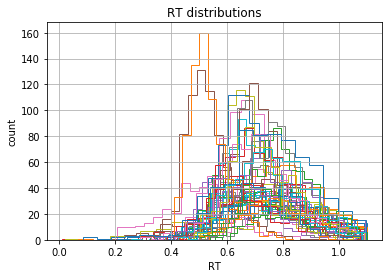

In [3]:
# load data
df1a = hddm.load_csv('df1a.v.hddm_stim.csv')

df1a.head(10)  # uncomment if you want to check the head of the data

# Uncomment the codes below if you are interested in checking the distribution of raw data
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df1a.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_MS_dat_M_match.pdf')

In [4]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    import random
    
    dbname='df1a_db_test_chain_%i'%id
    
    df1a = hddm.load_csv('df1a.v.hddm_stim.csv')

    df1a_subj = df1a['subj_idx'].unique()

    # random select without repetition
    random.seed(10)
    df1a_test_list = []
    for i in range(15):
        pos = random.randint(0, (len(df1a_subj)-1))
        df1a_test_list.append(df1a_subj[pos]) 
        #print(df1a_test_list)
    #print(df1a_test_list)  
    
    df1a_test = df1a[df1a['subj_idx'].isin(df1a_test_list)]
    
    m = hddm.HDDMStimCoding(df1a_test, 
                            include='z', 
                            stim_col='stim', 
                            depends_on={'v':['match','val'], 't':['match','val'],'a':['match','val']},
                            split_param='v', 
                            drift_criterion=False,
                            p_outlier=0.05)
    m.find_starting_values()
    m.sample(3000, burn=1500, dbname=dbname, db='pickle')
    m.save(dbname)
    
    return m

Test parallel processing

In [ ]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

Exception in callback BaseAsyncIOLoop._handle_events(53, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(53, 1)>
Traceback (most recent call last):
  File "/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 139, in _handle_events
    handler_func(fileobj, events)
  File "/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "<decorator-gen-153>", line 2, in _dispatch_reply
  

In [5]:
start_time = time.time()  # the start time of the processing

run_model(4)

print("\nRunning 1 chain used: %f seconds." % (time.time() - start_time))

running model4


/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1148.1 sec
Running 4 chains used: 1179.482265 seconds.
